# Seurat on ATAC

Running Seurat's LSI on ATAC data.

In [22]:
library(Seurat)
library(Matrix)
library(ggplot2)

In [9]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [5]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [7]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 414473      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10268_10885,chr1,10268,10885,chr1_10268_10885
chr1_41988_42505,chr1,41988,42505,chr1_41988_42505
chr1_46058_46558,chr1,46058,46558,chr1_46058_46558
chr1_48200_48959,chr1,48200,48959,chr1_48200_48959
chr1_51306_52190,chr1,51306,52190,chr1_51306_52190
chr1_58644_59144,chr1,58644,59144,chr1_58644_59144


In [10]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     5

,barcode,sample,umap1,umap2,cluster
,<fct>,<fct>,<dbl>,<dbl>,<int>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5


In [11]:
rownames(pmat) = rownames(metaData)
colnames(pmat) = rownames(peak_regions)

In [ ]:
atac <- CreateSeuratObject(counts = t(pmat), assay = "ATAC", project = "tmp")

In [ ]:
VariableFeatures(atac) <- names(which(Matrix::rowSums(atac) > 100))
atac <- RunLSI(atac, n = 50, scale.max = NULL)

In [28]:
atac <- RunUMAP(atac, reduction = "lsi", dims = 1:8)

04:15:11 UMAP embedding parameters a = 0.9922 b = 1.112

04:15:11 Read 53906 rows and found 8 numeric columns

04:15:11 Using Annoy for neighbor search, n_neighbors = 30

04:15:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

04:15:20 Writing NN index file to temp file /tmp/Rtmp1yy4zE/filec9951d4bcdb8

04:15:20 Searching Annoy index using 1 thread, search_k = 3000

04:15:39 Annoy recall = 100%

04:15:39 Commencing smooth kNN distance calibration using 1 thread

04:15:42 Initializing from normalized Laplacian + noise

04:15:45 Commencing optimization for 200 epochs, with 2050890 positive edges

04:16:13 Optimization finished



In [17]:
atac

An object of class Seurat 
414473 features across 53906 samples within 1 assay 
Active assay: ATAC (414473 features, 405111 variable features)
 2 dimensional reductions calculated: lsi, umap

In [18]:
atac[['sample']] = metaData$sample

In [19]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    guides(colour = guide_legend(title="Day",
         override.aes = list(shape=16, alpha=1, size=4)))
}

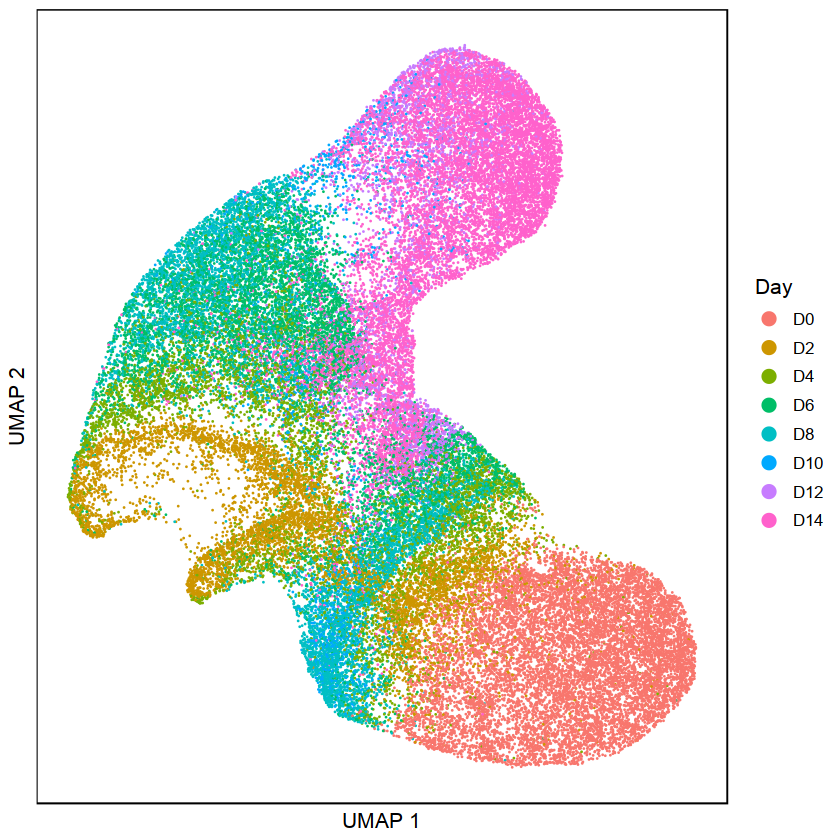

In [33]:
plot_dimred(data.frame(Embeddings(atac, reduction='umap'))$UMAP_2,
            -data.frame(Embeddings(atac, reduction='umap'))$UMAP_1,
            metaData$sample)